In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import time
import pandas as pd

In [2]:
#imports for interactive plots

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
#imports for sklearn

import sklearn as sk
from sklearn.datasets import make_circles
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge

In this problem we will learn how to use polynomial features to learn nonlinear classification
boundaries.
Previously, we found that linear regression can
be quite effective for classification. We applied it in the setting where the training data points
were approximately linearly separable. The term “linearly separable” in classification means there
exists a hyperplane such that most of the training data points in the first class are on one side of the
hyperplane and most training data points in the second class are on the other side of the hyperplane.

However, often times in practice classification datasets are not linearly separable in their native
representation. In such cases we can often find a representation that is linearly separable by augmenting the original data with appropriate features. This “lifting” embeds the data points into a higher
dimensional space where they are more likely to be linearly separable.
In this problem we consider several simple datasets of points (x1
, x2) ∈ R^2
, each associated with a binary
label bi which is −1 or +1. We then apply what we learned on a multi-class classification problem with 11 raw features.

# Section 0: Helper functions

**Part 1, 2, 3**: In this part, we provide some helper functions for regression problems. Complete the missing codes in assemble_feature(),poly_regression(), classify() and accuracy_percentage() based on the description of the functions

In [4]:
# helper functions
def draw_boundary(w,tol=1e-4,reg_type='linear',degree=2,n_grid =1000): 
    """this function draws the regression decision boundary"""
    x1_min = -2
    x1_max = 2
    x2_min =-2
    x2_max =2
 
    grid = np.zeros((n_grid*n_grid,2))
    temp1 = np.linspace(x1_min,x1_max,n_grid)
    temp2 = np.linspace(x2_min,x2_max,n_grid)
    
    for i in range(n_grid):
        grid[i*n_grid:(i+1)*n_grid,0] =temp1
        grid[i*n_grid:(i+1)*n_grid,1] = np.ones(n_grid)*temp2[i]
        
    if reg_type=='linear':    
        indicators =np.abs(grid.dot(w))<tol 
    elif reg_type=='poly':
        phi_grid = assemble_feature(grid,degree)
        indicators =np.abs(phi_grid.dot(w))<tol

    plt.scatter(grid[indicators, 0], grid[indicators, 1])
    pass


def draw_boundary_kernel(w,X_train,tol=1e-4,reg_type='linear',degree=2,n_grid =200): 
    """ this function draws the kernel regression decision boundary"""
    x1_min = -2
    x1_max = 2
    x2_min =-2
    x2_max =2
     
    grid = np.zeros((n_grid*n_grid,2))
    temp1 = np.linspace(x1_min,x1_max,n_grid)
    temp2 = np.linspace(x2_min,x2_max,n_grid)
    
    for i in range(n_grid):
        grid[i*n_grid:(i+1)*n_grid,0] =temp1
        grid[i*n_grid:(i+1)*n_grid,1] = np.ones(n_grid)*temp2[i]
        
    if reg_type=='linear':    
        indicators =np.abs(grid.dot(w))<tol 
    elif reg_type=='poly':
        phi_grid = assemble_feature(grid,degree)
        indicators =np.abs(phi_grid.dot(w))<tol
    elif reg_type=='poly_kernel':
        pred = poly_kernel(grid, X_train.T, degree) @ w
        indicators = np.abs(pred)<tol
    plt.scatter(grid[indicators, 0], grid[indicators, 1])
    pass


def poly_regression(X_train, y_train, X_test, lambda_=0):
    """ this function solve regression problem with X_train and y_train, and then makes a prediction with X_test """
    """ returns both the predicted values and the weight used """
    """ we need to use ridge regression later in the this problem."""
    """ for this, you will need to add a factor of "lambda_ * identity to X.T @ X before inverting" """
    #TO DO 0 start
    w = np.linalg.solve(X_train.T @ X_train + lambda_ * np.eye(X_train.shape[1]), X_train.T @ y_train)
    y_predict = X_test @ w
    #TO DO 0 end
    return y_predict, w




def classify(ypred):
    '''This function classifies the predicted vector ypred into two classes {-1, +1}'''
    #TO DO 1 start
    for i in range(ypred.shape[0]):
      if ypred[i] <= 0:
        ypred[i] = -1
      else:
        ypred[i] = 1
    #TO DO 1 end
    return ypred

def accuracy_percentage(y_true, y_predict):
    '''This function calculates percentage of correct prediction'''
    #TO DO 2 start
    accuracy= 1.0*np.sum(y_predict == y_true) / len(y_true)
    return accuracy
    #TO DO 2 end

def assemble_feature(x, D):
    '''This function takes in the raw data matrix and return a data matrix with d degree polynomials
       For example, if input is (x1, x2) and D =2, output will be a matrix consisting of columns [1,x1,x2,x1*x2,x1^2,x2^2]
       Do not use any sklearn functions to do this. We want you to explicitly construct the monomials'''
    #TO DO 3 start
    n_feature = x.shape[1]
    Q = [(np.ones(x.shape[0]), 0, 0)]
    i = 0
    while Q[i][1] < D:
        cx, degree, last_index = Q[i]
        for j in range(last_index, n_feature):
            Q.append((cx * x[:, j], degree + 1, j))
        i += 1
    return np.column_stack([q[0] for q in Q])
    #TO DO 3 end

# Section 1: Building the algorithm with Circle data

**Part 4(i)** Visualize the data: Let's import our Circle data and visualize it. Do you expect linear or polynomial regression to work better? Why?

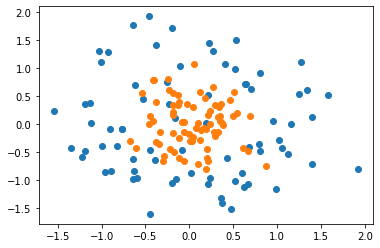

In [5]:
# Generate data and relabel points so classes are {-1, +1}
X_cir = np.load("X_circle.npy")
y_cir = np.load("y_circle.npy")
n = y_cir.shape[0]

# Split data into training, validation, and test sets
ratio_train = 0.625
ratio_val =0.125
ratio_test =0.25
n_train = int(ratio_train*n)
n_val = int(ratio_val*n)
n_test = int(ratio_test*n)
X_cir_train = X_cir[0:n_train, 0:2]
y_cir_train = y_cir[0:n_train]

X_cir_val = X_cir[n_train:n_train+n_val, 0:2]
y_cir_val = y_cir[n_train:n_train+n_val]

X_cir_test = X_cir[n_train+n_val:, 0:2]
y_cir_test = y_cir[n_train+n_val:]

# Visualize data
def visualize_dataset(X, y):
    plt.scatter(X[y < 0.0, 0], X[y < 0.0, 1])
    plt.scatter(X[y > 0.0, 0], X[y > 0.0, 1])
    plt.show()

visualize_dataset(X_cir, y_cir)

**Part 4(i)**: [[Your observations]] 

Answer: The data is not linearly separable so I expect that linear regression will do poorly. Polynomial regression will perform better after we lift the raw data to a polynomial featurization.

**Part 4(ii)**: Complete the following part to see what happens when we do regression directly with raw features. You may find the helper functions in Section 0 useful. What do you see? Is this consistent with what you expected?

Test accuracy on the test set is  0.41025641025641024


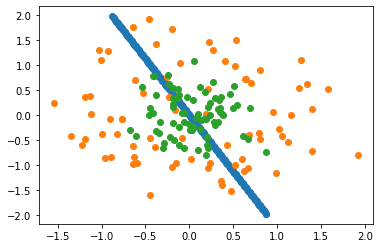

In [6]:
# Model a linear regression

#using linear regression to train the training data set and make prediction on the test set
# TO DO 4 start 
y_cir_predict, w1 = poly_regression(X_cir_train, y_cir_train,X_cir_test, lambda_=0)
prediction_acc = accuracy_percentage(y_cir_test, classify(y_cir_predict))
# TO DO 4 end

print("Test accuracy on the test set is ", prediction_acc)
draw_boundary(w1,1e-4)
visualize_dataset(X_cir, y_cir)

**Part 4(ii)**: [[Your observations]]

Answer: As expected, linear regression does poorly with a accuracy rate ~40%. This is because drawing a hyperplace through the data will always have half of each class on either side of the boundary.

**Part 5**: Now complete the missing codes to lift our data with polynomial features, and see how it helps with learning process. Feel free to play with the degree of the polynomial features but report the test accuracy for a 2-degree polynomial. Is this consistent with what you expected?

Test accuracy on the test set is  0.8974358974358975


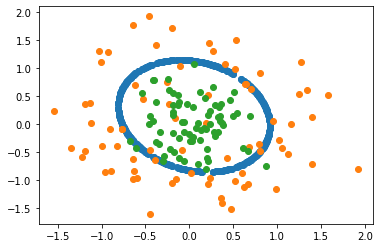

In [7]:
degree_poly = 2

# Model a 2-degree polynomial regression
# TO DO 5 start
Phi_cir = assemble_feature(X_cir_train, degree_poly)
Phitest_cir = assemble_feature(X_cir_test, degree_poly) 
ypred_cir, w_cir = poly_regression(Phi_cir, y_cir_train, Phitest_cir, lambda_=0)
prediction_acc = accuracy_percentage(y_cir_test, classify(ypred_cir))
# TO DO 5 end

print("Test accuracy on the test set is ", prediction_acc)
draw_boundary(w_cir,1e-3,'poly',degree_poly)
visualize_dataset(X_cir, y_cir)

**Part 5**: [[Your observations]]

Answer: Polynomial regression performs much better because it allows us to have a nonlinear boundary. In this case, the boundary is shaped like a circle so we need a 2-degree polynomial to model x^2 + y^2 = r^2.

**Part 6**: Below is an interactive plot showing the decision boundary with different degree of the polynomial features. Makes observations on how the decision boundary change as you increase the degree. Also, pay attention to the run time as the degree increases. Write your observations and comments below 

In [8]:
def interactive_poly(degree_poly):

    Phi_cir = assemble_feature(X_cir_train, degree_poly)
    Phitest_cir = assemble_feature(X_cir_test, degree_poly) 

    y_predict_cir, w_cir = poly_regression(Phi_cir, y_cir_train, Phitest_cir, lambda_=0)
    acc_perc = accuracy_percentage(y_cir_test, classify(y_predict_cir))

    print("Test accuracy on the test set is ", acc_perc)
    draw_boundary(w_cir,1e-2,'poly',degree_poly)
    visualize_dataset(X_cir, y_cir)
    pass

interact(interactive_poly,degree_poly=widgets.IntSlider(min=1, max=10, step=1, value=3))

interactive(children=(IntSlider(value=3, description='degree_poly', max=10, min=1), Output()), _dom_classes=('…

<function __main__.interactive_poly>

**Part 6**: [[Your observations]] 

Answer: As we increase the polynomial degree, we begin to observe "overfitting." The bias decreases and the variance increases as we increase the degree which means that while training accuracy may increase, the test accuracy will decrease.

**Part 7**: Try different degrees of polynomials and try to find best degree using the validation process. Complete the following code to generate a plot of the prediction accuracy vs the degree of the polynomial. Comment on the difference between train accuracy and validation accuracy. Also write your observations on the run time plot

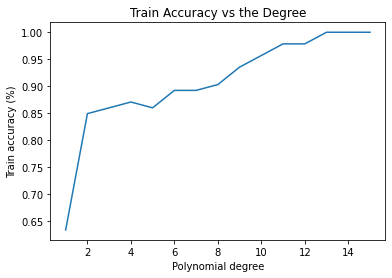

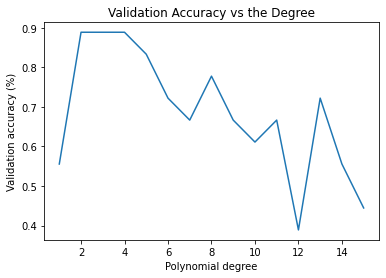

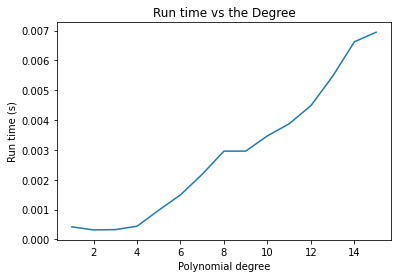

In [9]:
LAMBDA = 0
max_d =16

accs_train =[]
accs_val =[]
run_times=[]
for D in range(1, max_d):
    start_time = time.process_time()
    # Model a polynomial regression using train data and test on validation data
    # TO DO 7 start:
    Xd_cir_train = assemble_feature(X_cir_train, D)
    Xd_cir_val = assemble_feature(X_cir_val, D)

    ypred_train_cir, w_cir = poly_regression(Xd_cir_train, y_cir_train, Xd_cir_train, lambda_=LAMBDA)
    ypred_val_cir, w_cir = poly_regression(Xd_cir_train, y_cir_train, Xd_cir_val, lambda_=LAMBDA)

    acc_train = accuracy_percentage(y_cir_train, classify(ypred_train_cir))
    acc_val = accuracy_percentage(y_cir_val, classify(ypred_val_cir))
    # TO DO 7 end:

    end_time = time.process_time()
    run_times.append(end_time-start_time)
    accs_train.append(acc_train)
    accs_val.append(acc_val)

# Plot train accuracy as a function of polynomial degree
plt.plot(range(1,max_d),accs_train)
plt.xlabel('Polynomial degree')
plt.ylabel('Train accuracy (%)')
plt.title('Train Accuracy vs the Degree')
plt.show();

# Plot validation accuracy as a function of polynomial degree
plt.plot(range(1,max_d),accs_val)
plt.title('Validation Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Validation accuracy (%)')
plt.show();

# Plot run time as a function of polynomial degree
plt.plot(range(1,max_d),run_times)
plt.title('Run time vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Run time (s)')
plt.show();

**Part 7**: What is the best degree for this mdoel? Does this makes sense to you intuitively based on the shape of this data set?  Comment on how run time changes with the degree. Why is this happening?

[[Your observations]]

Answer: Best degree is 2 (up to 4) and yes it is consistent. The run time increases as we increase the degree. This is because the number of features increases exponentially with respect to the degree increasing. Hence (X.T @ X) ^{-1} becomes computationall very expensive (the resulting matrix product is very large and taking the inverse is O(n^3) where n is the size of the square matrix).

**Part 8**: Complete the following part to train on train and validation set, and evaluate on test set. Report the test accuracy 

In [10]:
# Train model on train and validation set, evaluate on test set

D = 3
# TO DO 8 start:
X_cir_train_set = np.concatenate((X_cir_train, X_cir_val), axis=0)
y_cir_train_set = np.concatenate((y_cir_train, y_cir_val), axis=0)

phi_train_cir = assemble_feature(X_cir_train_set, D)
phi_test_cir = assemble_feature(X_cir_test, D)

y_predict_cir, w_cir = poly_regression(phi_train_cir, y_cir_train_set, phi_test_cir, lambda_=0)
accuracy_test = accuracy_percentage(y_cir_test, classify(y_predict_cir))

# TO DO 8 end:

print("Prediction accuracy on the test set is ", accuracy_test)

Prediction accuracy on the test set is  0.8974358974358975


**Part 9**: Now lets compare regression with polynomial features with polynomial kernel regression. Fill in the polynomial kernel equation i.e. create the gram matrix. Run the following codes, and write down your observations

In [11]:
def poly_kernel(X, XT, D):
    """Create the polynomial order D kernel matrix from X and X^T"""
    #TO DO 9 start:
    K = np.power(X @ XT + 1, D)
    #TO DO 9 end:
    return K

# Helper function for interactive plot
def interactive_poly_kernel(D):
  LAMBDA =0.001
  K_cir = poly_kernel(X_cir_train, X_cir_train.T, D) + LAMBDA * np.eye(X_cir_train.shape[0])
  w_cir_k = np.linalg.solve(K_cir, y_cir_train)

  ypred_train_cir_k = poly_kernel(X_cir_train, X_cir_train.T, D) @ w_cir_k
  acc_train = accuracy_percentage(y_cir_train, classify(ypred_train_cir_k))
  print("Prediction accuracy on the train set is ", acc_train)

  ypred_test_cir_k = poly_kernel(X_cir_test, X_cir_train.T, D) @ w_cir_k
  acc_test = accuracy_percentage(y_cir_test, classify(ypred_test_cir_k))
  print("Prediction accuracy on the test set is ", acc_test)


  draw_boundary_kernel(w_cir_k,X_cir_train,1e-1,'poly_kernel',D,200)
  visualize_dataset(X_cir, y_cir)
  pass

# Visualize interactive plot for boundary by polynomial degree
interact(interactive_poly_kernel,D=widgets.IntSlider(min=1, max=10, step=1, value=2))

interactive(children=(IntSlider(value=2, description='D', max=10, min=1), Output()), _dom_classes=('widget-int…

<function __main__.interactive_poly_kernel>

**Part 9**:
[[Your observations]]

Answer: Polynomial kernel behaves similarly to regression with polynomial features. We observe the same overfitting as we increase the degree of polynomial.

**Part 10**: Run the following codes to plot accuracy and run time vs the degree for kernel regression method. Compare and contrast accuracy and run time between polynomial kernel regression and regression with polynomial features. Write down your observations.

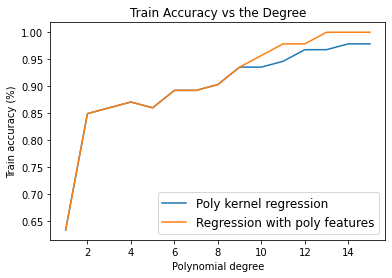

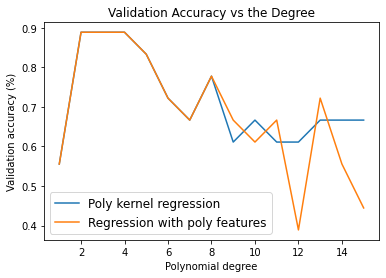

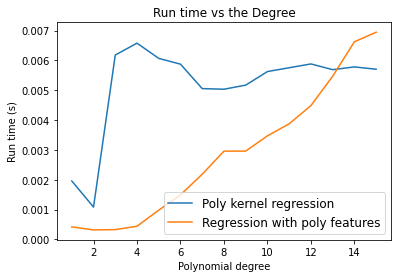

In [12]:
LAMBDA = 0.001
max_d =16

accs_train_k =[]
accs_val_k =[]
run_times_k=[]

# Model polynomial regression with degree 1 through max_d for circle data
for D in range(1, max_d):
    start_time = time.process_time()

    K_cir = poly_kernel(X_cir_train, X_cir_train.T, D) + LAMBDA * np.eye(X_cir_train.shape[0])
    w_cir_k = np.linalg.solve(K_cir, y_cir_train)

    ypred_train_cir_k = poly_kernel(X_cir_train, X_cir_train.T, D) @ w_cir_k
    acc_train = accuracy_percentage(y_cir_train, classify(ypred_train_cir_k))

    ypred_val_cir_k = poly_kernel(X_cir_val, X_cir_train.T, D) @ w_cir_k
    acc_val = accuracy_percentage(y_cir_val, classify(ypred_val_cir_k))


    end_time = time.process_time()
    run_times_k.append(end_time-start_time)
    accs_train_k.append(acc_train)
    accs_val_k.append(acc_val)

# Plot train accuracy as a function of degree
plt.plot(range(1,max_d),accs_train_k, label='Poly kernel regression')
plt.plot(range(1,max_d),accs_train,label='Regression with poly features')
plt.xlabel('Polynomial degree')
plt.ylabel('Train accuracy (%)')
plt.title('Train Accuracy vs the Degree')
plt.legend(fontsize=12)
plt.show();

# Plot validation accuracy as a function of degree
plt.plot(range(1,max_d),accs_val_k,label='Poly kernel regression')
plt.plot(range(1,max_d),accs_val,label='Regression with poly features')
plt.title('Validation Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Validation accuracy (%)')
plt.legend(fontsize=12)
plt.show();

# Plot run time as a function of degree
plt.plot(range(1,max_d),run_times_k,label='Poly kernel regression')
plt.plot(range(1,max_d),run_times,label='Regression with poly features')
plt.title('Run time vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Run time (s)')
plt.legend(fontsize=12)
plt.show();


**Part 10**:
[[Your observations]]

Answer: Accuracies between polynomial kernel and regression with polynomial features are very similar. However, run time differs greatly. When the polynomial degree is small, kernel is more computationall expensive. This is because there is a "fixed" cost to creating the gram matrix which is dependent on the number of points in the dataset. However, as the degree increases, kernel outperforms polynomial features. This is because (as mentioned above) increasing the degree exponentially increases the number of polynomial features needed. We need to invert a very large matrix (dependent on the number of features), whereas the gram matrix from kernel is dependent on the number of data points (due to the inner product between points). When the number of features >> number of data points, kernel becomes much more efficient.

# Section 2: Star data

Part 11: Let's try our developed algorithm with more complicated data boundary. Here is a different data set. Run the following block of codes to visualize the data. Intuitvely, what is your guess for best degree in this case. 

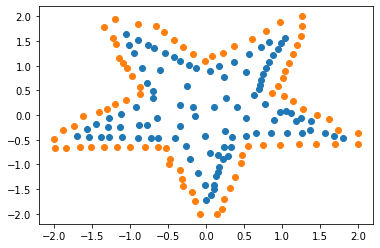

In [13]:
# Load data
X_star = np.load("X_star.npy")
y_star = np.load("y_star.npy")

# Split into train and test data
ratio_train = 0.8
ratio_test =0.2

n_train = int(ratio_train*len(y_star))

n_test = int(ratio_test*len(y_star))
X_star_train = X_star[0:n_train, 0:2]
y_star_train = y_star[0:n_train]

X_star_test = X_star[n_train:, 0:2]
y_star_test = y_star[n_train:]

# Visualize data
visualize_dataset(X_star, y_star)



**Part 11**: [[Your observations]]

Answer: The data is shapped like a star with a more complex border than a circle. We expect it to need a higher degree polynomial (~5).

**Part 12**: Play with the interactive plot below and also study the accuracy plots. What is the best degree in this case? Why is it different from the best degree for previous data set? 

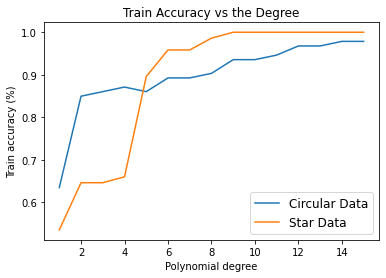

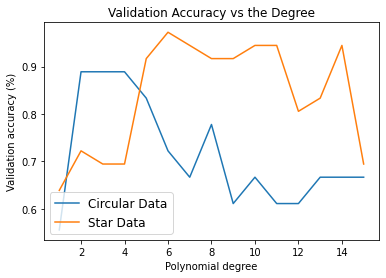

interactive(children=(IntSlider(value=2, description='D', max=16, min=1), Output()), _dom_classes=('widget-int…

<function __main__.interactive_star>

In [14]:
LAMBDA = 0.001
max_d =16

accs_train_star =[]
accs_val_star =[]

# Model star data boundary using polynomial regression with degree 1 through max_d
for D in range(1, max_d):
    # Use poly kernel to run a polynomial regression
    K_star = poly_kernel(X_star_train, X_star_train.T, D) + LAMBDA * np.eye(X_star_train.shape[0])
    w_star = np.linalg.solve(K_star, y_star_train)

    ypred_train_k = poly_kernel(X_star_train, X_star_train.T, D) @ w_star
    acc_train = accuracy_percentage(y_star_train, classify(ypred_train_k))

    ypred_test_k = poly_kernel(X_star_test, X_star_train.T, D) @ w_star
    acc_test = accuracy_percentage(y_star_test, classify(ypred_test_k))

    accs_train_star.append(acc_train)
    accs_val_star.append(acc_test)

# Plot accuracies for Circle and Star data
plt.plot(range(1,max_d),accs_train_k, label='Circular Data')
plt.plot(range(1,max_d),accs_train_star,label='Star Data')
plt.title('Train Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Train accuracy (%)')
plt.legend(fontsize=12)
plt.show();

plt.plot(range(1,max_d),accs_val_k,label='Circular Data')
plt.plot(range(1,max_d),accs_val_star,label='Star Data')
plt.title('Validation Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Validation accuracy (%)')
plt.legend(fontsize=12)
plt.show();

# Visualize interactive plot for how the boundary changes with respect to polynomial degree
def interactive_star(D):
  K_star = poly_kernel(X_star_train, X_star_train.T, D) + LAMBDA * np.eye(X_star_train.shape[0])
  w_star = np.linalg.solve(K_star, y_star_train)

  ypred_star_test = poly_kernel(X_star_test, X_star_train.T, D) @ w_star
  acc_star = accuracy_percentage(y_star_test, classify(ypred_star_test))
  print("prediction accuracy on the train set is ", acc_star)


  draw_boundary_kernel(w_star,X_star_train,1e-1,'poly_kernel',D,200)
  visualize_dataset(X_star, y_star)
  pass

interact(interactive_star,D=widgets.IntSlider(min=1, max=16, step=1, value=2))

**Part 12**: [[Your observations]]

Answer: The best degree is 6. Again this is because the star has a more complicated boundary than the circle data. This means we need a more complex feature space to accurately model the boundary.

# Section 3: Multiclass problem

Part 13: Instead of two classes, we will have data points in four classes in this new dataset. The four class labels are -3,-1,1, and 3. That is, the class label yi for data point xi will take one of the above values depending on its class. Run the code below to visualize the data. Intuitively, what do you think the best degree will be?

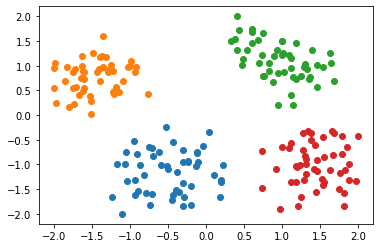

In [15]:
# Load four class data
X_four = np.load("X_four.npy")
y_four = np.load("y_four.npy")

# Split data into train and test
ratio_train = 0.8
ratio_test =0.2

n_train = int(ratio_train*len(y_four))

n_test = int(ratio_test*len(y_four))
X_four_train = X_four[0:n_train, 0:2]
y_four_train = y_four[0:n_train]

X_four_test = X_four[n_train:, 0:2]
y_four_test = y_four[n_train:]

# Visualize data
plt.scatter(X_four[y_four==-3, 0], X_four[y_four==-3, 1])
plt.scatter(X_four[y_four==-1, 0], X_four[y_four==-1, 1])
plt.scatter(X_four[y_four==1, 0], X_four[y_four==1, 1])
plt.scatter(X_four[y_four==3, 0], X_four[y_four==3, 1])
plt.show()

**Part 13**: [[Your observations]]

Answer: This problem is more complex than the previous two examples since we have more classes. We expect the degree to be at least something bigger than 6 (the best degree from the star problem). 

**Part 14**: Complete the classification function classify_four_classes(ypred) and run the following codes. Verify your guess on the best degree. Comment on what you find.




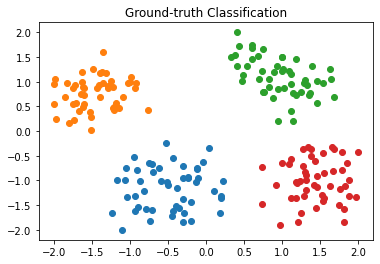

interactive(children=(IntSlider(value=2, description='D', max=16, min=1), Output()), _dom_classes=('widget-int…

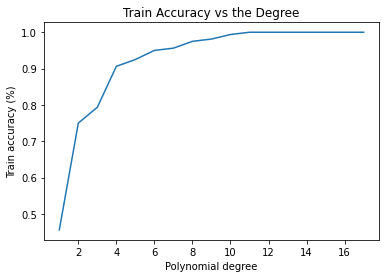

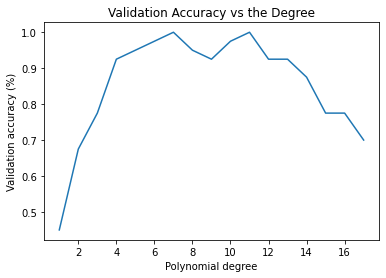

In [16]:
def classify_four_classes(ypred):
# Classify ypred into labels {-3, -1, +1, +3} by creating reasonable boundaries
    # TO DO 14 start: 
    for i in range(ypred.shape[0]):
      if ypred[i] <= -2.5:
        ypred[i] = -3
      elif ypred[i] <= 0:
        ypred[i] = -1
      elif ypred[i]<=2.5:
        ypred[i] =1
      else:
        ypred[i]=3
    # TO DO 14 end:
    
    return ypred

# Visualize the true labels
plt.scatter(X_four[y_four==-3, 0], X_four[y_four==-3, 1])
plt.scatter(X_four[y_four==-1, 0], X_four[y_four==-1, 1])
plt.scatter(X_four[y_four==1, 0], X_four[y_four==1, 1])
plt.scatter(X_four[y_four==3, 0], X_four[y_four==3, 1])
plt.title('Ground-truth Classification')
plt.show()

# Visualize how the classes change based on our polynomial regression model
LAMBDA = 0.001
def interactive_circles(D):
  K_four = poly_kernel(X_four_train, X_four_train.T, D) + LAMBDA * np.eye(X_four_train.shape[0])
  w_four = np.linalg.solve(K_four, y_four_train)

  ypred_four_test = classify_four_classes(poly_kernel(X_four_test, X_four_train.T, D) @ w_four)
  acc_four = accuracy_percentage(y_four_test, ypred_four_test)
  
  ypred_four = classify_four_classes(poly_kernel(X_four, X_four_train.T, D) @ w_four)

  plt.scatter(X_four[ypred_four==-3, 0], X_four[ypred_four==-3, 1])
  plt.scatter(X_four[ypred_four==-1, 0], X_four[ypred_four==-1, 1])
  plt.scatter(X_four[ypred_four==1, 0], X_four[ypred_four==1, 1])
  plt.scatter(X_four[ypred_four==3, 0], X_four[ypred_four==3, 1])
  plt.title('Learned Classification')
  plt.show()
  print("Prediction accuracy on the test set is ", acc_four)
  pass

interact(interactive_circles,D=widgets.IntSlider(min=1, max=16, step=1, value=2))

max_d =18
accs_train_four =[]
accs_test_four =[]

# Model a polynomial regression for degrees 1 through max_d
for D in range(1, max_d):
    K_four = poly_kernel(X_four_train, X_four_train.T, D) + LAMBDA * np.eye(X_four_train.shape[0])
    w_four = np.linalg.solve(K_four, y_four_train)

    ypred_train_k = classify_four_classes(poly_kernel(X_four_train, X_four_train.T, D) @ w_four)
    acc_train = accuracy_percentage(y_four_train, ypred_train_k)

    ypred_test_k = classify_four_classes(poly_kernel(X_four_test, X_four_train.T, D) @ w_four)
    acc_test = accuracy_percentage(y_four_test, ypred_test_k)

    acc_train = accuracy_percentage(y_four_train, ypred_train_k)
    acc_test = accuracy_percentage(y_four_test, ypred_test_k)

    accs_train_four.append(acc_train)
    accs_test_four.append(acc_test)

# Visualize accuracy rates as a function of polynomial degree
plt.plot(range(1,max_d),accs_train_four,label='Four Classes')
plt.title('Train Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Train accuracy (%)')
plt.show();

plt.plot(range(1,max_d),accs_test_four,label='Four Classes')
plt.title('Validation Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Validation accuracy (%)')
plt.show();

**Part 14**: [[Your observations]]

Answer: Indeed the best degree was 11 (>6) with test accuracy 100%. This is consistent with our guess.

#Section 4: Training with wine data

 The wine quality dataset archives a numerical description to 1600 different kinds of wine. There are 12 numerical values to describe the property of each wine in the dataset. The first 11 values can be seen as the input features. While the twelfth value is a integer output label varies from from 1 to 10, which evaluates the quality of each wine. Our goal is to use the 11-D input feature vector and the 1-D output label to train a machine learning model, using polynomial regression techniques. 

In this question, you will start with pre-processing a real-world dataset to have a basic understanding to the dataset and the task. Then we will walk you through some tricky problems in machine learning with the problem setting and the starter code, to gain you some intuition on how to deal with the defects of a dataset. At the end we want you to compare the accuracy and the efficiency of different machine learning implementation by observing the behaviors of them. Working on the question will help you roughly see how real-world machine learning would be like. 

This dataset is available from the UCI machine learning repository (see https://archive.ics.uci.edu/ml/datasets/wine+quality).





First let's load the data. Before applying any learning algorithm to the wine dataset, we will first preprocess the dataset. In the real-world, pre-processing the data is a very important step since real-life data can be quite imperfect. Since the raw data matrix is not normalized and contains large values that can cause overflow. We will first rescale each column of the data matrix to the same scale and then perform regression on the new data matrix. Complete the function rescale_matrix() and run the following code to load the data. Play with interactive plot to visualize data with two selected features. Based on your observations on the interactive plot, do you think this data set is linearly separable? 

In [17]:
X_wine = np.load("X_wine.npy")
X_wine_train = np.load("X_wine_train.npy")
X_wine_test = np.load("X_wine_test.npy")
X_wine_val = np.load("X_wine_val.npy")

y_wine = np.load("y_wine.npy")
y_wine_train = np.load("y_wine_train.npy")
y_wine_test = np.load("y_wine_test.npy")
y_wine_val = np.load("y_wine_val.npy")

# rescale the range of each feature to be from minValue and maxValue 
def rescale_matrix(X,maxValue,minValue):
  n1,n2 = X.shape
  Xp = np.zeros(X.shape)
  # in the following section, you will rescale the data matrix and save it as Xp
  # In Xp, each feature has maximal feature value equals to maxValue, and minimal value equals to minValue
  #TO DO 15 start:
  for i in range(n2):
    temp =X[:,i] 
    temp = temp-np.min(temp)
    temp= temp/np.max(temp)*(maxValue-minValue)
    Xp[:,i]=temp+minValue  
  #TO DO 15 end:
  return Xp

maxValue = 2
minValue =-2
X_wine = rescale_matrix(X_wine,minValue,maxValue)
X_wine_train = rescale_matrix(X_wine_train,minValue,maxValue)
X_wine_val = rescale_matrix(X_wine_val,minValue,maxValue)
X_wine_test = rescale_matrix(X_wine_test,minValue,maxValue)

def visualize_wine_2D(X,y,feature1,feature2):
  # feature1 and feature2 are indices from 0 to 10
  labels =['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']

  n1,n2 = X.shape

  x1 = X[:,feature1]
  x2 = X[:,feature2]

  for i in range(10):
    plt.scatter(x1[y==i], x2[y==i])
  plt.title('Data with '+labels[feature1]+' and '+labels[feature2])
  plt.show()
  pass

def interactive_visualize_wine_2D(feature1,feature2):
  visualize_wine_2D(X_wine_train,y_wine_train,feature1,feature2)

interact(interactive_visualize_wine_2D, feature1=widgets.IntSlider(min=0, max=10, step=1, value=0), feature2=widgets.IntSlider(min=0, max=10, step=1, value=1)) 


interactive(children=(IntSlider(value=0, description='feature1', max=10), IntSlider(value=1, description='feat…

<function __main__.interactive_visualize_wine_2D>

**Part 16**: [[Your observations]]

Answer: No matter which features you map against each other, it doesn't appear that the data is linearly separable. This implies linear regression will fail in this situation. We will need a more complex model.

Now let's try learn the data using regression with polynomial features. The output of regression is a continuous variable. Complete the function classify_wine() below to convert the continuous variable into the wine quality score (ie. the class label for each data point). Also, complete the missing codes in the function visualize_wine_regression_results() to do regression with polynomial on this data set. Run the code and make your observations. The interactive plot shows the prediction labels vs the ground-truth label for selected degree of polynomial. Play with this plot, and report the best degree.Comment on effectiveness on training this data set. 

In [18]:

def classify_wine(y):
  # This function take the learned y value, and output the classified ypred into 10 classes
  #TODO 17 start
  ypred = np.zeros(len(y))
  for i in range(len(y)):
    if y[i]>9.5:
      ypred[i] =10
    elif y[i]>8.5:
      ypred[i] =9
    elif y[i]>7.5:
      ypred[i] =8
    elif y[i]>6.5:
      ypred[i] =7
    elif y[i]>5.5:
      ypred[i] =6
    elif y[i]>4.5:
      ypred[i] =5
    elif y[i]>3.5:
      ypred[i] =4
    elif y[i]>2.5:
      ypred[i] =3
    elif y[i]>1.5:
      ypred[i] =2
    else:
      ypred[i] =1
    #TODO 17 end
  return ypred.astype(int)

def visualize_wine_regression_results(X_train,y_train,D,X_test,y_test):
  #TODO 18 start
  phi = assemble_feature(X_train,D)
  phi_test =assemble_feature(X_test,D)
  ypoly,w =poly_regression(phi, y_train, phi_test, 0)
  #TODO 18 end

  for i in range(10):
    plt.scatter(y_test[y_test==i],ypoly[y_test==i])
  plt.title('Prediction on test data with '+ str(D) + ' degree polynomial features')
  plt.ylabel('Predicted quality values')
  plt.xlabel('Actual wine quality')
  plt.xlim(0,10)
  plt.ylim(0,10)
  plt.show() 

  acc_wine_test = accuracy_percentage(y_test,classify_wine(ypoly))
  print('Prediction accuracy on test data: ',acc_wine_test) 
  pass

def interactive_visualize_wine_regression_results(D):
  visualize_wine_regression_results(X_wine_train,y_wine_train,D,X_wine_test,y_wine_test)
 
interact(interactive_visualize_wine_regression_results, D = widgets.IntSlider(min=1, max=12, step=1, value=1)) 

interactive(children=(IntSlider(value=1, description='D', max=12, min=1), Output()), _dom_classes=('widget-int…

<function __main__.interactive_visualize_wine_regression_results>

**Part 19**: [[Your obervations on the prediction results]]

Answer: The best degree is 3 or 5 but all are pretty similarly bad. Doing polynomial regression does not seem to be effective.

Plot histogram of the data labels. Write down your observations. Based on your observations, what could be one of the reasons that causes the low prediction accuracy in the previous cell?

<function matplotlib.pyplot.show>

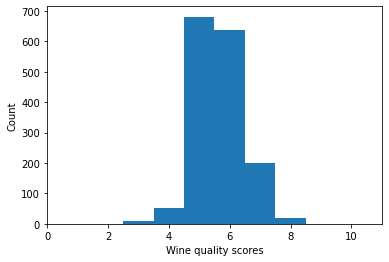

In [19]:
# plot a historgram of the original data
# TO DO 20
plt.hist(y_wine, bins=[0.5, 1.5, 2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
# TO DO 20

plt.xlabel('Wine quality scores')
plt.ylabel('Count')
plt.show

**Part 20**: [[Your answer]]

Answer: amount of data points in different classes is not balanced. Regression results will be biased.

Now let's complete the missing code below to rebin the data into two classes (with class labels -1 and 1) so that two classes will have a similar number of data points. The histogram above might give you a hint on how to split the data. Note that in real life, if you are asked to predict wine quality score, this approach is not going to help. You will likely have to use a more complex modeling algorithm. But for this exercise, we will just simplify the problem to be applicable to polynomial regression. The following two parts are aimed to show that a signficant class imbalance can produce poor prediction results.

In [20]:
# rebin ten classes into two classes
yr_wine =np.zeros(len(y_wine))
yr_wine_train=np.zeros(len(y_wine_train))
yr_wine_test=np.zeros(len(y_wine_test))
yr_wine_val=np.zeros(len(y_wine_val))

#TO DO 21 start
#  in this part, define yr_wine, yr_wine_train, yr_wine_test and yr_wine_val so that they take on labels {-1, +1}
yr_wine[y_wine<=5] = -1*np.ones(np.sum(y_wine<=5))
yr_wine[y_wine>5] = np.ones(np.sum(y_wine>5))

yr_wine_train[y_wine_train<=5] = -1*np.ones(np.sum(y_wine_train<=5))
yr_wine_train[y_wine_train>5] = np.ones(np.sum(y_wine_train>5))

yr_wine_test[y_wine_test<=5] = -1*np.ones(np.sum(y_wine_test<=5))
yr_wine_test[y_wine_test>5] = np.ones(np.sum(y_wine_test>5))

yr_wine_val[y_wine_val<=5] = -1*np.ones(np.sum(y_wine_val<=5))
yr_wine_val[y_wine_val>5] = np.ones(np.sum(y_wine_val>5))
#TO DO 21 end



**Part 22**: First let's try to learn the rebined wine data using regression with polynomial features.  In this problem, we give you the value for LAMBDA. Make sure to use plug this value in for lambda_ in poly_regression() instead of using the default value when filling the missing code. Compare the performance with before and comment your observations below. Change different degree of polynomials under 10, and report the max degree you can run on this data set. Why do you think training this data set is significantly slower?

Note: in the starter code, we provided the LAMBDA (regularization hyperparameter) value used for ridge regression. You will learn about ridge regression in detail later this week, but for now, all you need to know that using ridge regression helps deal with noise via a concept called "regularization." For real-life data that is always subject to noise, proper regularization is critical to achieving an ideal performance. This hybrid model can remind you that in real-world machine learning practice, you can try any appropriate tool for a task to pursue the best performance.

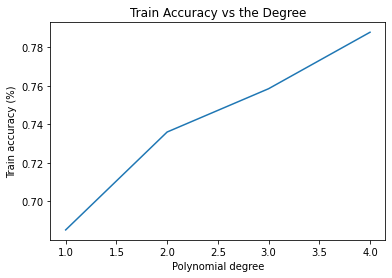

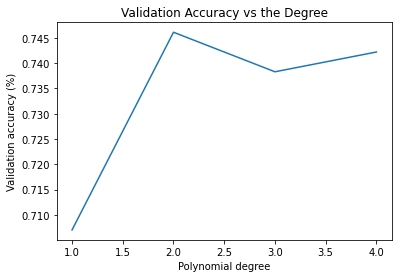

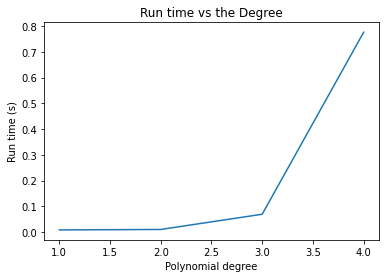

interactive(children=(IntSlider(value=2, description='D', max=15, min=1), Output()), _dom_classes=('widget-int…

<function __main__.interactive_wine_acc>

In [21]:
# regression with poly features

LAMBDA=5000
max_d =5

accs_train_wine =[]
accs_val_wine =[]
run_times_wine=[]
for D in range(1, max_d):
    start_time = time.process_time()

    # complete the following part to train on X_wine_train and report predicton accuracy on X_wine_val
    # make sure to use ridge regression
    # TO DO 22 start:
    Xd_wine_train = assemble_feature(X_wine_train, D)
    Xd_wine_val = assemble_feature(X_wine_val, D)

    ypred_train_wine, w_wine = poly_regression(Xd_wine_train, yr_wine_train, Xd_wine_train, lambda_=LAMBDA)
    ypred_val_wine, w_wine = poly_regression(Xd_wine_train, yr_wine_train, Xd_wine_val, lambda_=LAMBDA)      
    acc_train = accuracy_percentage(yr_wine_train, classify(ypred_train_wine))
    acc_val = accuracy_percentage(yr_wine_val, classify(ypred_val_wine))

    # TO DO 22 end:

    end_time = time.process_time()
    run_times_wine.append(end_time-start_time)
    accs_train_wine.append(acc_train)
    accs_val_wine.append(acc_val)

# Plot train accuracy as a function of polynomial degree
plt.plot(range(1,max_d),accs_train_wine, label='Your regression with poly features')
plt.title('Train Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Train accuracy (%)')
plt.show();

# Plot validation accuracy as a function of polynomial degree
plt.plot(range(1,max_d),accs_val_wine, label='Your regression with poly features')
plt.title('Validation Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Validation accuracy (%)')
plt.show();

# Plot run time as a function of polynomial degree
plt.plot(range(1,max_d),run_times_wine, label='Your regression with poly features')
plt.title('Run time vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Run time (s)')
plt.show();



def interactive_wine_acc(D):
  Xd_wine_train = assemble_feature(X_wine_train, D)
  Xd_wine_test = assemble_feature(X_wine_test, D)
  ypred_test,w =poly_regression(Xd_wine_train, yr_wine_train, Xd_wine_test,LAMBDA)
 
  acc_test = accuracy_percentage(yr_wine_test, classify(ypred_test))

  print("Prediction accuracy on the test set is ", acc_test)


  pass

interact(interactive_wine_acc,D=widgets.IntSlider(min=1, max=15, step=1, value=2))

**Part 22**: [[Your observations]]

Answer: After re-binning the data, polynomial regression performs significantly better. But we can't run the algorithm with high degree polynomial like before. This is because the data set is a lot larger, and therefore it is a lot more computationally expensive to train.

**Part 23**: Now try to use poly kernel regression to train the rebined wine data set. Are you able to run the train the data with higher degree polynomials? Why? 

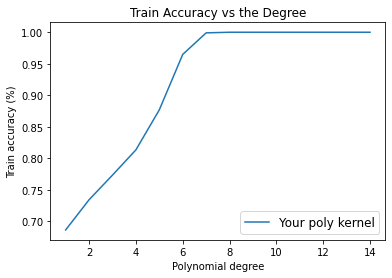

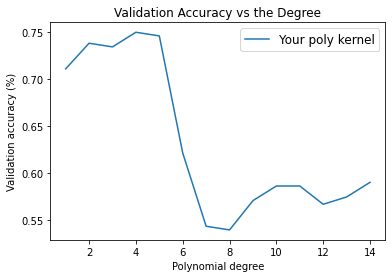

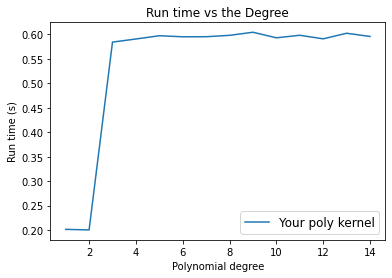

interactive(children=(IntSlider(value=2, description='D', max=15, min=1), Output()), _dom_classes=('widget-int…

<function __main__.interactive_wine_acc_k>

In [22]:
# kernel regression

LAMBDA=6000

max_d =15

accs_train_wine_k =[]
accs_val_wine_k =[]
run_times_wine_k =[]

for D in range(1, max_d):
    start_time = time.process_time()

    # make sure to use ridge regression
    # TO DO 23 start
    K_wine = poly_kernel(X_wine_train, X_wine_train.T, D) + LAMBDA * np.eye(X_wine_train.shape[0])
    w_wine = np.linalg.solve(K_wine, yr_wine_train)

    ypred_train_k_wine = classify(poly_kernel(X_wine_train, X_wine_train.T, D) @ w_wine)
    acc_train = accuracy_percentage(yr_wine_train, ypred_train_k_wine)

    ypred_val_k_wine = classify(poly_kernel(X_wine_val, X_wine_train.T, D) @ w_wine)
    acc_val = accuracy_percentage(yr_wine_val, ypred_val_k_wine)
    # TO DO 23 end

    end_time = time.process_time()

    accs_train_wine_k.append(acc_train)
    accs_val_wine_k.append(acc_val)
    run_times_wine_k.append(end_time-start_time)

# Plot accuracies for Circle and Star data
plt.plot(range(1,max_d),accs_train_wine_k, label='Your poly kernel')
plt.title('Train Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Train accuracy (%)')
plt.legend(fontsize=12)
plt.show();

plt.plot(range(1,max_d),accs_val_wine_k,label='Your poly kernel')
plt.title('Validation Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Validation accuracy (%)')
plt.legend(fontsize=12)
plt.show();

plt.plot(range(1,max_d),run_times_wine_k,label='Your poly kernel')
plt.title('Run time vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Run time (s)')
plt.legend(fontsize=12)
plt.show();


def interactive_wine_acc_k(D):
  K_wine = poly_kernel(X_wine_train, X_wine_train.T, D) + LAMBDA * np.eye(X_wine_train.shape[0])
  w_wine = np.linalg.solve(K_wine, yr_wine_train)

  ypred_wine_test = classify(poly_kernel(X_wine_test, X_wine_train.T, D) @ w_wine)
  acc_star = accuracy_percentage(yr_wine_test, ypred_wine_test)
  print("Prediction accuracy on the test set is ", acc_star)

  pass

interact(interactive_wine_acc_k,D=widgets.IntSlider(min=1, max=15, step=1, value=2))

**Part 23**: [[Your observations]]

Your answer:

I can run kernel regression with degree up to 15. This is because kernel regression is less expensive on calculating high degree polynomials

Scikit-learn is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy. In general, using a machine learning library will enormously speed up your coding process. You should be able to implement a more complicated machine learning model, i.e. combining more than one machine learning algorithm in a model by simply calling library functions. 

The following two parts are aimed to get you familiar with sklearn library. You will read the documentation of sklearn functions to try to implement regression with polynomial features and polynomial kernel regression with sklearn function. You may find the following sections of sklearn library useful: sklearn.preprocessing, sklearn.linear_model.LinearRegression and sklearn.kernel_ridge.

Note: As we did in the manual implementation for polynomial regression earlier, we will need to include some regularization via ridge regression when using sklearn to implement polynomial regression. In this case, be sure to use Ridge() which we imported for you and the value for LAMBDA which we also provided for you. Again, you will learn about ridge in more detail later this week so don't worry about the details for now.



**Part 24**: First try regression with polynomial features. Complete the missing codes. What is the best D in this case? How does it compare with results from your implementation?

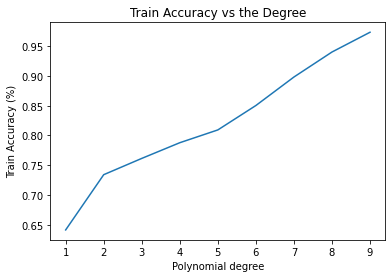

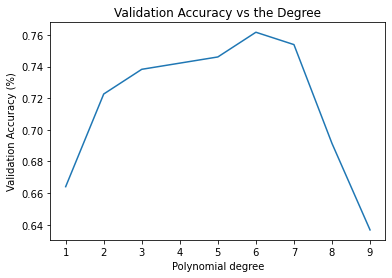

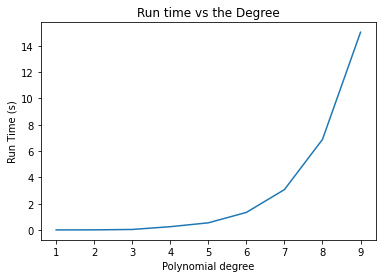

interactive(children=(IntSlider(value=2, description='D', max=15, min=2), Output()), _dom_classes=('widget-int…

<function __main__.interactive_visualize_wine_sk_regression>

In [23]:
from sklearn.linear_model import Ridge

ALPHA =6000


# plot accuracy
max_d = 10
accs_train_wine_sk = []
accs_val_wine_sk = []
run_times_wine_sk =[]
for D in range(1, max_d):
    
    start_time = time.process_time()

    # make sure to use ridge regression
    #TO DO 24 start: 
    poly = PolynomialFeatures(D)
    phi_wine = poly.fit_transform(X_wine_train) 
    phi_val_wine =poly.fit_transform(X_wine_val)

    reg = Ridge(alpha=ALPHA)
    reg.fit(phi_wine, yr_wine_train)
    ypoly_train_wine = reg.predict(phi_wine)  
    ypoly_val_wine = reg.predict(phi_val_wine) 
    acc_wine_train = accuracy_percentage(yr_wine_train,classify(ypoly_train_wine))
    acc_wine_val = accuracy_percentage(yr_wine_val,classify(ypoly_val_wine))
    #TO DO 24 end:

    end_time = time.process_time()
    run_times_wine_sk.append(end_time-start_time)
    accs_train_wine_sk.append(acc_wine_train)
    accs_val_wine_sk.append(acc_wine_val)
    

    
plt.plot(range(1,max_d),accs_train_wine_sk,label='SK regression with poly features')
plt.title('Train Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Train Accuracy (%)')
plt.show();

plt.plot(range(1,max_d),accs_val_wine_sk,label='SK regression with poly features')
plt.title('Validation Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Validation Accuracy (%)')
plt.show();


plt.plot(range(1,max_d),run_times_wine_sk,label='SK regression with poly features')
plt.title('Run time vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Run Time (s)')
plt.show();

def visualize_wine_sk_regression(X_train,y_train,D,X_test,y_test):

  poly = PolynomialFeatures(D)
  phi = poly.fit_transform(X_train)
  phi_test =poly.fit_transform(X_test)
  reg = Ridge(alpha=ALPHA)
  reg.fit(phi, y_train)
  ypoly = reg.predict(phi_test)


  acc_wine_test = accuracy_percentage(y_test,classify(ypoly))
  print('Prediction accuracy on test data: ',acc_wine_test) 
  pass

def interactive_visualize_wine_sk_regression(D):
  visualize_wine_sk_regression(X_wine_train,yr_wine_train,D,X_wine_test,yr_wine_test)

interact(interactive_visualize_wine_sk_regression,D=widgets.IntSlider(min=2, max=15, step=1, value=2))





**Part 24**: [[Your answer]]

Answer: The Sklearn version is a bit more efficient on trainin this data set. We can run the algorithm with degree up to 10. But in terms of test accuracy, my implementation and Sklearn implementation have no difference. The accuracies are both around 72%.

**Part 25**: 
Repeat with sklearn.kernel_ridge to do poly kernel regression with sklearn functions. What is the best D in this case? How does it compare with results from your implementation?

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.03152e-16): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.21844e-18): result may not be accurate.
  overwrite_a=False)


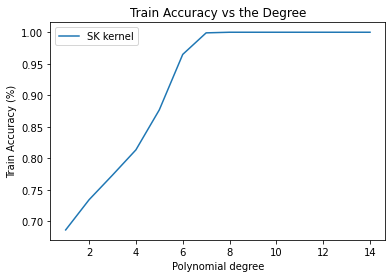

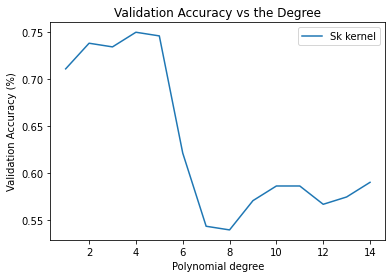

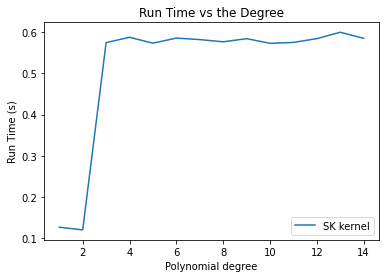

interactive(children=(IntSlider(value=4, description='D', max=15, min=1), Output()), _dom_classes=('widget-int…

<function __main__.interactive_visualize_wine_sk_kernel>

In [24]:
# plot accuracy
ALPHA =6000
max_d = 15
accs_train_wine_sk_kernel = []
accs_val_wine_sk_kernel = []
run_times_wine_sk_kernel = []

for D in range(1, max_d):
    
    start_time = time.process_time()

    # make sure to use ridge regression
    #TO DO 25 start:
    clf = KernelRidge(alpha=ALPHA,kernel='polynomial',degree=D,gamma=1)
    clf.fit(X_wine_train, yr_wine_train)
    ypoly_train_wine =clf.predict(X_wine_train)
    ypoly_val_wine =clf.predict(X_wine_val)

    acc_wine_train = accuracy_percentage(yr_wine_train,classify(ypoly_train_wine))
    acc_wine_val = accuracy_percentage(yr_wine_val,classify(ypoly_val_wine))
    #TO DO  25 end: 


    end_time = time.process_time()

    run_times_wine_sk_kernel.append(end_time-start_time)
    accs_train_wine_sk_kernel.append(acc_wine_train)
    accs_val_wine_sk_kernel.append(acc_wine_val)
    


plt.plot(range(1,max_d),accs_train_wine_sk_kernel,label='SK kernel')
plt.title('Train Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Train Accuracy (%)')
plt.legend()
plt.show();


plt.plot(range(1,max_d),accs_val_wine_sk_kernel,label='Sk kernel')
plt.title('Validation Accuracy vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show();



plt.plot(range(1,max_d),run_times_wine_sk_kernel,label='SK kernel')
plt.title('Run Time vs the Degree')
plt.xlabel('Polynomial degree')
plt.ylabel('Run Time (s)')
plt.legend()
plt.show();



def visualize_wine_sk_kernel(X_train,y_train,D,ALPHA,X_test,y_test):
 

  clf = sk.kernel_ridge.KernelRidge(alpha=ALPHA,kernel='polynomial',degree=D)
  clf.fit(X_train, y_train)
  ypoly =clf.predict(X_test)


  acc_wine_test = accuracy_percentage(y_test,classify(ypoly))
  print('Prediction accuracy on test data: ',acc_wine_test) 
  pass

def interactive_visualize_wine_sk_kernel(D):
  visualize_wine_sk_kernel(X_wine_train,yr_wine_train,D,ALPHA,X_wine_test,yr_wine_test)

interact(interactive_visualize_wine_sk_kernel,D=widgets.IntSlider(min=1, max=15, step=1, value=4))

**Part 25**: [[Your answer]]

Answer: The training results for poly kernel regression from Sklearn are almost identical to those from our implementation. And the run time for both implementations are the same too. We believed that there are no major difference between the two.